# Figure 1 - shadow models trained by the classical adversary + re-alignment

This notebook shows the first layer activation maps of the target model and shadow models trained by the classical adversary, given as input the same image of an airplane.

It then shows the first layer activation maps of re-aligned shadow models, using the bottom-up correlation matching re-alignment technique.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import torch

sys.path.insert(0, '../')

from src.dataset import get_num_classes, load_dataset
from src.models import init_model

In [2]:
dataset_size = 0
dataset_name = 'cifar10'
architecture = 'cnn-large'
num_classes = get_num_classes(dataset_name)

dataset = load_dataset(dataset=dataset_name, transform='normalize', dataset_size=dataset_size, seed=42, path='../data')
train_and_test = dataset['train_and_test']

Files already downloaded and verified


Load an image of an airplane and save it to disk.

Label 0


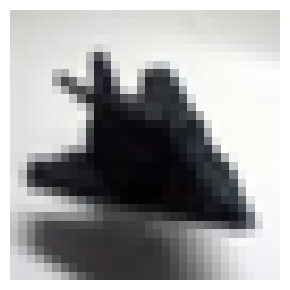

In [3]:
tidx = 29
target_record, label = train_and_test[tidx]
print('Label', label)

def imshow(img):
    plt.subplots(figsize=(3, 3))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/airplane.pdf')
    plt.show()
    plt.close()

imshow(target_record)

In [4]:
@torch.no_grad()
def get_activation_maps(model, image, layer=1):
    C, D1, D2 = image.size()
    output1 = model.conv1(image.view(1, C, D1, D2))
    if layer == 1:
        return output1.squeeze(0)
    elif layer == 2:
        output2 = model.conv2(output1).view(50, 5, 5)
        return output2
    else:
        raise ValueError(f'ERROR: Invalid layer {layer}.')

Load models trained on the CIFAR10 dataset by the classical adversary, i.e., using different weight initialisation, batch ordering, and dropout sampling, and disjoint dataset.

In [5]:
experiments_dir = f'../experiments/{dataset_name}/controlled_randomness/{architecture}/dsize-12500'
print('Experiments path', experiments_dir)
num_experiments = 6

Experiments path ../experiments/cifar10/controlled_randomness/cnn-large/dsize-12500


In [6]:
print('Loading the models')
models = dict({'seed_all_dataset_disjoint': []})
for key in models:
    models_dir = os.path.join(experiments_dir, key)
    for exp in range(num_experiments):
        models_path = os.path.join(models_dir, f'exp_{exp}_model.pickle')
        if not os.path.exists(models_path):
            continue
        with open(models_path, 'rb') as f:
            saved_model = pickle.load(f)
        model = init_model(architecture, num_classes, verbose=False)
        model.load_state_dict(saved_model['model_state_dict'])
        model.eval()
        models[key].append(model)
    print(f'Found {len(models[key])} models for the {key} experiment.')

Loading the models
Found 4 models for the seed_all_dataset_disjoint experiment.


## Visualisation of shadow models trained by the classical adversary.

_Note 1:_  We post-processed 'plots/seed_all_dataset_disjoint_12500_0.01.pdf' (generated below) in a PDF editor to add colored squares for similar activation maps across different models.

_Note 2:_ It takes a few seconds to generate the visualisations.

Target model (layer 1)


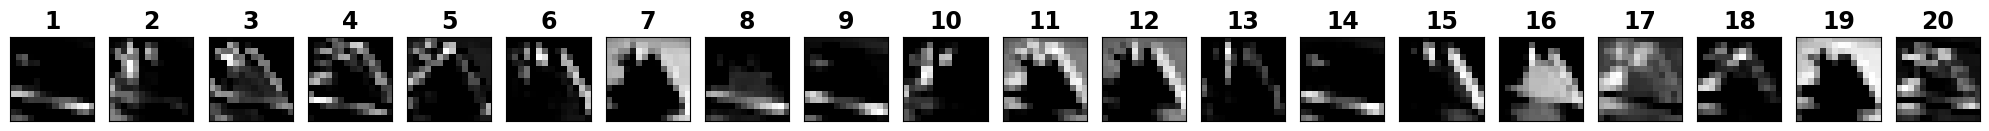

Varying the seed_all_dataset_disjoint source of randomness.


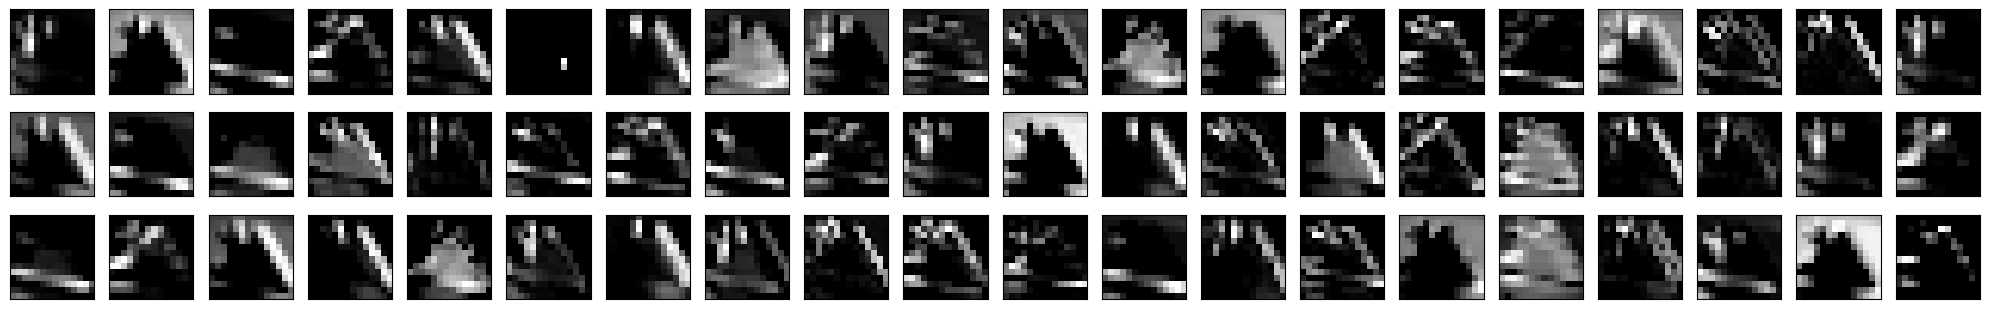

In [7]:
layer = 1

# Printing the target model first. This is model #1. The shadow models are models #1-#3. There are only
# three shadow models in the `seed_all_dataset_disjoint` setting because they have to be trained on
# disjoint subsets of CIFAR10 - train (of size 50000) and we have used a subset size of 12500 for
# all the models.
assert 'seed_all_dataset_disjoint' in models
fig, axes = plt.subplots(1, 20, figsize=(20, 1.5))
target_model = models['seed_all_dataset_disjoint'][0]
maps = get_activation_maps(target_model, target_record, layer=layer)
layer_viz = maps.data
print(f'Target model (layer 1)')
for i, filter in enumerate(layer_viz):
    if i == layer_viz.size(0): 
        break
    axes[i].imshow((filter-filter.min())/(filter.max()-filter.min()), vmin=0, vmax=1, cmap='gray')
    axes[i].tick_params(axis='both',
                             which='both',# both major and minor ticks are affected
                             bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    axes[i].set_title(f'{i+1}', fontsize=17, fontweight='bold')
plt.tight_layout()
plt.savefig(f'plots/target_model_12500_0.01.pdf', bbox_inches='tight')
plt.show()
plt.close()

for key in models:
    print(f'Varying the {key} source of randomness.')
    fig, axes = plt.subplots(len(models[key])-1, 20, figsize=(20, 20/6))
    for exp in range(1, len(models[key]), 1):
        maps = get_activation_maps(models[key][exp], target_record, layer=layer)
        layer_viz = maps.data
        for i, filter in enumerate(layer_viz):
            if i == layer_viz.size(0): 
                break
            axes[exp-1][i].imshow((filter-filter.min())/(filter.max()-filter.min()), vmin=0, vmax=1, cmap='gray')
            axes[exp-1][i].tick_params(
                axis='both',
                which='both',# both major and minor ticks are affected
                bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.tight_layout()
    plt.savefig(f'plots/{key}_12500_0.01.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

# Visualise the re-aligned shadow models (under the classical adversary)

_Note:_ It takes a few seconds to generate the visualisations.

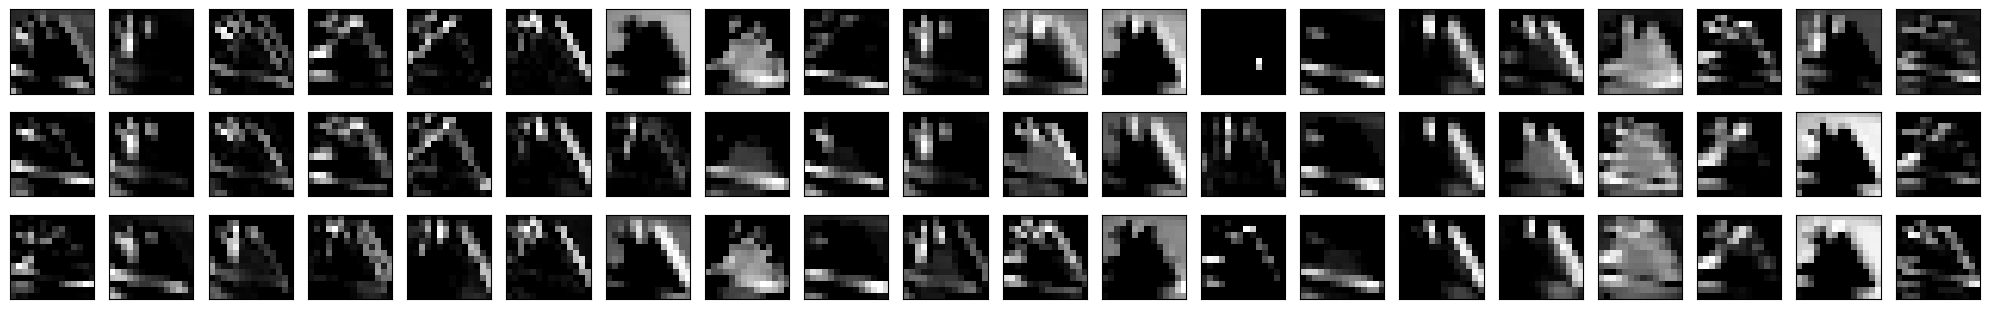

In [8]:
key = 'seed_all_dataset_disjoint'

# Records used to perform the re-alignment.
batch_records = torch.cat([train_and_test[i][0].unsqueeze(0) for i in range(500)], dim=0)

import importlib
import src.align
importlib.reload(src.align)
from src.align import (HungarianAlgorithmMatching,
    BottomUpCorrelationMatchingBasedAlignment)

fig, axes = plt.subplots(len(models[key])-1, 20, figsize=(20, 20/6))
for exp in range(1, len(models[key]), 1):
    model = models[key][exp]
    aligned_model = BottomUpCorrelationMatchingBasedAlignment(HungarianAlgorithmMatching()).align_layers(
        model, target_model, records=batch_records)
    maps = get_activation_maps(aligned_model, target_record, layer=layer)
    layer_viz = maps.data
    for i, filter in enumerate(layer_viz):
        if i == layer_viz.size(0): 
            break
        axes[exp-1][i].imshow((filter-filter.min())/(filter.max()-filter.min()), vmin=0, vmax=1, cmap='gray')
        axes[exp-1][i].tick_params(
            axis='both',
            which='both',# both major and minor ticks are affected
            bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig(f'plots/aligned_{key}_12500_0.01.pdf', bbox_inches='tight')
plt.show()
plt.close()